In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import skew

In [2]:
with pd.HDFStore('./large_files/data_20240328.h5', mode='r') as store:
    df_ = store.get('data/cl')
df_.info(verbose=3)

<class 'pandas.core.frame.DataFrame'>
Index: 2537990 entries, 0 to 2539786
Data columns (total 10 columns):
 #   Column    Dtype                           
---  ------    -----                           
 0   date      object                          
 1   time      object                          
 2   open      float64                         
 3   high      float64                         
 4   low       float64                         
 5   close     float64                         
 6   volume    int64                           
 7   datetime  datetime64[ns, America/New_York]
 8   day       object                          
 9   month     int64                           
dtypes: datetime64[ns, America/New_York](1), float64(4), int64(2), object(3)
memory usage: 213.0+ MB


In [8]:
df = df_.set_index('datetime')
df = df.between_time('10:00', '16:00')
df = df[(df.index.year >= 2019) & (df.index.year < 2024)]
df.head()

,date,time,open,high,low,close,volume,day,month
datetime,,,,,,,,,
2019-01-02 10:00:00-05:00,2019-01-02,1000,44.88,45.01,44.88,45.00,2314,Wednesday,1
2019-01-02 10:01:00-05:00,2019-01-02,1001,45.00,45.03,44.89,45.02,1725,Wednesday,1
2019-01-02 10:02:00-05:00,2019-01-02,1002,45.02,45.11,44.99,45.08,2513,Wednesday,1
2019-01-02 10:03:00-05:00,2019-01-02,1003,45.07,45.10,45.05,45.09,1537,Wednesday,1
2019-01-02 10:04:00-05:00,2019-01-02,1004,45.09,45.23,45.08,45.21,3642,Wednesday,1


In [68]:
def fn(x):
    if x.shape[0] == 0:
        return np.nan
    return (x.iloc[-1] -x.iloc[0]) / x.iloc[0]

df_volatility = []
for day, df_day in df.groupby(pd.Grouper(level='datetime', freq='D')):
    if df_day.shape[0] == 0:
        continue
    
    df_day = df_day.copy()
    df_day['returns_1m'] = df_day['close'].pct_change()
    df_day['returns_5m'] = df_day['close'].resample('5min').apply(fn)
    df_day['returns_15m'] = df_day['close'].resample('15min').apply(fn)
    df_day['returns_30m'] = df_day['close'].resample('30min').apply(fn)
    df_day.at[df_day.index[-1], 'returns_1d'] = (df_day['close'].iloc[-1] - df_day['close'].iloc[0]) / df_day['close'].iloc[0]
    df_volatility.append(df_day)

df_volatility = pd.concat(df_volatility)
df_volatility.tail()

,date,time,open,high,low,close,volume,day,month,returns_1m,returns_5m,returns_15m,returns_30m,returns_1d
datetime,,,,,,,,,,,,,,
2023-12-29 15:56:00-05:00,2023-12-29,1556,71.38,71.38,71.36,71.37,29,Friday,12,-0.00014,NaN,NaN,NaN,NaN
2023-12-29 15:57:00-05:00,2023-12-29,1557,71.37,71.38,71.36,71.37,36,Friday,12,0.00000,NaN,NaN,NaN,NaN
2023-12-29 15:58:00-05:00,2023-12-29,1558,71.37,71.37,71.36,71.37,74,Friday,12,0.00000,NaN,NaN,NaN,NaN
2023-12-29 15:59:00-05:00,2023-12-29,1559,71.37,71.40,71.37,71.38,111,Friday,12,0.00014,NaN,NaN,NaN,NaN
2023-12-29 16:00:00-05:00,2023-12-29,1600,71.38,71.39,71.35,71.39,95,Friday,12,0.00014,0.0,0.0,0.0,-0.013405


<Axes: >

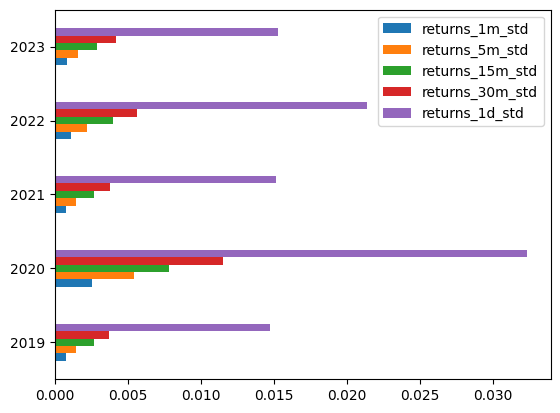

In [69]:
years = df_volatility.index.year.unique().tolist()
df_years = pd.DataFrame()
for year in years:
    df_year = df_volatility[df_volatility.index.year == year]
    df_years.at[year, 'returns_1m_std'] = df_year.returns_1m.dropna().std()
    df_years.at[year, 'returns_5m_std'] = df_year.returns_5m.dropna().std()
    df_years.at[year, 'returns_15m_std'] = df_year.returns_15m.dropna().std()
    df_years.at[year, 'returns_30m_std'] = df_year.returns_30m.dropna().std()
    df_years.at[year, 'returns_1d_std'] = df_year.returns_1d.dropna().std()


df_years.plot.barh()

<Axes: >

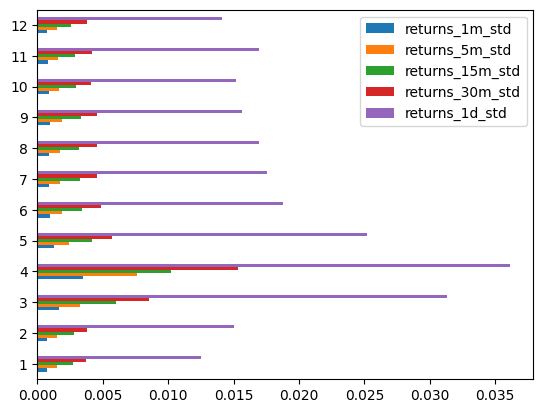

In [70]:
months = df_volatility.index.month.unique().tolist()
df_months = pd.DataFrame()
for month in months:
    df_month = df_volatility[df_volatility.index.month == month]
    df_months.at[month, 'returns_1m_std'] = df_month.returns_1m.dropna().std()
    df_months.at[month, 'returns_5m_std'] = df_month.returns_5m.dropna().std()
    df_months.at[month, 'returns_15m_std'] = df_month.returns_15m.dropna().std()
    df_months.at[month, 'returns_30m_std'] = df_month.returns_30m.dropna().std()
    df_months.at[month, 'returns_1d_std'] = df_month.returns_1d.dropna().std()

df_months.plot.barh()

In [67]:
day_vol = df['close'].resample('D').apply(fn).dropna()

for month in months:
    df_month = day_vol[day_vol.index.month == month]